### Computational simulation for Multi-Armed Bandit with Thompson Sampling

In [42]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#### set-up parameters:

In [43]:
# total numbers of simulations:
sim_total = 50

# total times of interactions:
number_of_turns = 40

# total number of machines:
number_of_slot_machines = 4

# average reward rates:
conversion_rates = np.array([0.9, 0.9, 0.9, 0.9])
# conversion_rates = np.array([0.1, 0.3, 0.5, 0.9])

# prior bias:
prior_pos = 1
prior_neg = 1
# prior_pos = 10
# prior_neg = 1

#### set-up the environment and actions:

In [44]:
playedmost = []
highestpm = []
interaction_time = []
posterior_mean = []

sim_total = sim_total
for sim in range(sim_total):

    
    '''
    create datasets - the environment
    '''
    
    # define the total number of turns
    number_of_turns = number_of_turns

    # define the total number of slot machines
    number_of_slot_machines = number_of_slot_machines

    # define arrays where we can keep track of our wins (positive rewards) 
    # and losses (negative rewards) for each slot init with zeros
    number_of_positive_rewards = np.zeros(number_of_slot_machines)
    number_of_negative_rewards = np.zeros(number_of_slot_machines)

    # create a random conversion rate for each slot
    # 0.9, 0.9, 0.9, 0.9 vs. 0.1, 0.3, 0.5, 0.9
    conversion_rates = conversion_rates

    # generate a fake dataset
    # define a seed for the random number generator (one simulation one seed)
    np.random.seed(int(time.time()))

    # the dataset is a matrix with one row for each turn, and one column for each slot
    # each item in the matrix represents the outcome of what would happen if we were to play a
    # particular slot on that particular turn. A value of "1" indicates that we would win,
    # while a value of "0" indicates that we would lose.
    # the number of "wins" for each slot is determined by its conversion rate (defined above).

    # create a 2d numpy array, and fill it with zeros
    outcomes = np.zeros((number_of_turns, number_of_slot_machines))
    # fill-in 1 to outcomes, according to conversion rates.
    for slot_machine_index in range(number_of_slot_machines):
        outcomes[np.random.choice(np.arange(number_of_turns),
                                  int(conversion_rates[slot_machine_index]*number_of_turns),
                                  replace=False),
                 slot_machine_index] = 1
    
    
    '''
    play the game - actions
    '''
    
    
    # assign slot 3 with a prior
    prior_pos = prior_pos
    prior_neg = prior_neg
    number_of_positive_rewards[3] = prior_pos
    number_of_negative_rewards[3] = prior_neg

    # for each turn
    d={i:[] for i in range(number_of_slot_machines)}
    for turn_index in range(number_of_turns):
        index_of_machine_to_play = -1
        max_beta = -1

        # determine which slot machine to play for this turn
        # for each slot
        for slot_machine_index in range(number_of_slot_machines):
            # define the shape parameters for the beta distribution. The shape will depend on the number
            # of wins and losses that have thus far been observed for this particular slot machine.
            a = number_of_positive_rewards[slot_machine_index] + 1
            b = number_of_negative_rewards[slot_machine_index] + 1

            d[slot_machine_index].append(a/(a+b))

            # get a random value from the beta distribution whose shape is defined by the number of
            # wins and losses that have thus far been observed for this slot machine
            random_beta = np.random.beta(a, b)

            # if this is the largest beta value thus far observed for this iteration
            if random_beta > max_beta:
                # update the maximum beta value thus far observed
                max_beta = random_beta
                
                '''
                Thompson sampling (v. random sampling)
                '''
                # THOMPSON SAMPLING: set the machine to play to the current machine
                index_of_machine_to_play = slot_machine_index
                
                # RANDOM SAMPLING: pick up a random machine to play
                # index_of_machine_to_play = np.random.randint(0, number_of_slot_machines)
                ''''''

        # play the selected slot, and record whether we win or lose
        if outcomes[turn_index][index_of_machine_to_play] == 1:
            number_of_positive_rewards[index_of_machine_to_play] += 1
        else:
            number_of_negative_rewards[index_of_machine_to_play] += 1

    # compute and display the total number of times each slot was played
    number_of_times_played = number_of_positive_rewards + number_of_negative_rewards
    # for each slot
    # for slot_machine_index in range(number_of_slot_machines):
    #     print('Slot machine {0} was played {1} times'.format(slot_machine_index, number_of_times_played[slot_machine_index]))

    # identify and display the best slot machine to play
    # print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

    # record # times played with the highest prior slot
    playedmost.append(np.argmax(number_of_times_played))
    # record which slot gave the highest pm
    highestpm.append(np.argmax([d[0][-1],d[1][-1],d[2][-1],d[3][-1]]))

    # times of interaction sorted
    interaction_time.extend(np.sort(number_of_times_played))

    # posterior mean sorted
    for i in range(number_of_turns):
        posterior_mean.extend(sorted([d[0][i],d[1][i],d[2][i],d[3][i]]))

    sim += 1
    # make sure every sim uses a new seed
    time.sleep(1)


#### visualize results

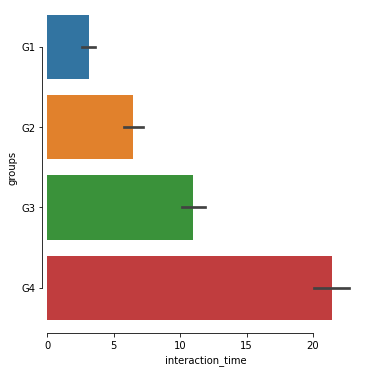

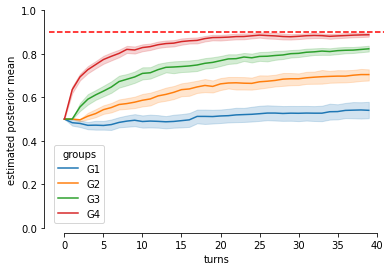

In [45]:
# visualize interaction time.
arms = ['G1', 'G2', 'G3', 'G4'] * sim_total
df = pd.DataFrame(list(zip(arms, interaction_time)), columns=['groups','interaction_time'])
ax = sns.catplot(x='interaction_time', y='groups', kind="bar", data=df)
sns.despine(offset=5, trim=True)
plt.show()


# visualize posterior mean.
turn = []
for i in range(number_of_turns):
    turn += [i] * number_of_slot_machines
turns = turn * sim_total
arms = ['G1', 'G2', 'G3', 'G4'] * number_of_turns * sim_total
df = pd.DataFrame(list(zip(turns, arms, posterior_mean)), columns=['turns','groups','posterior_mean'])
ax = sns.lineplot(x="turns", y="posterior_mean", hue="groups", data=df)
ax.set(xlabel='turns', ylabel='estimated posterior mean')
ax.set(ylim=(0, 1))
ax.axhline(.90, ls='--',color='r')
#ax.axhline(.50, ls='--',color='g')
#ax.axhline(.30, ls='--',color='orange')
#ax.axhline(.10, ls='--',color='b')
sns.despine(offset=5, trim=True)
plt.show()
